In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm
DATA_PATH = "../"
data_path = DATA_PATH + "data_new/"

# example file
# file = data_path + "JA4331_05_02_23_000000.csv"
# data = pd.read_csv(file)

In [2]:
csv_files = [file for file in os.listdir(data_path) if file.endswith(".csv")]
print(csv_files)

def get_prefix(file: str) -> str:
    return file[:2]


def get_mouse_id(file: str) -> str:
    return file.split("_")[0][2:]


def get_session_date(file: str) -> str:
    day, month, year = file.split("_")[1:4]
    return "20" + year + month + day


def get_session_id(file: str) -> str:
    return file.split("_")[-1].split(".")[0]


def add_id_cols(df: pd.DataFrame, file: str) -> pd.DataFrame:
    df["mouse_id"] = get_mouse_id(file)
    df["session_id"] = get_session_id(file)
    df["session_date"] = get_session_date(file)
    df["prefix"] = get_prefix(file)
    df["uid"] = file.split(".")[0]
    return df


def map_delta_gain_column(x: int) -> str:
    mapping = {
        8: "++",
        6: "+",
        2: "+",
        0: "0",
        -2: "-",
        -6: "-",
        -8: "--",
    }
    return mapping[x]


def pivot_data(data: pd.DataFrame) -> pd.DataFrame:
    gain_change_df = data.melt(
        id_vars=[
            "prev_track_length",
            "delta_gain",
            "glitch_degrees",
            "Unnamed: 0",
        ]
    ).rename(
        columns={
            "variable": "Time Aligned to Gain Change (sec)",
            "value": "dF/F",
            "Unnamed: 0": "Trial number",
            "glitch_degrees": "Phase shift",
            "delta_gain": "Gain Change Magnitude",
        }
    )
    gain_change_df["Gain Change Magnitude"] = gain_change_df[
        "Gain Change Magnitude"
    ].apply(map_delta_gain_column)
    return gain_change_df

['JA4331_05_06_23_0000.csv', 'JA5365_05_06_23_0000.csv', 'JA4331_05_04_23_0000.csv', 'JS4_04_10_23_000000.csv', 'JS4_04_05_23_000000.csv', 'JA5365_05_07_23_0000.csv', 'JS4_04_13_23_000000.csv', 'JA4331_05_02_23_000000.csv', 'JA4331_05_04_23_0003.csv', 'JA5365_05_02_23_000000.csv', 'JA4331_05_05_23_0000.csv', 'JA4331_05_03_23_000000.csv', 'JA5365_05_04_23_0000.csv', 'JA5351_04_10_23_000000.csv', 'JA4331_05_07_23_0000.csv']


In [3]:
dfs = []
for file in tqdm(csv_files):
    print(f"Processing file {file}")
    data = pd.read_csv(data_path + file)
    dfs.append(add_id_cols(pivot_data(data), file))

data_df = pd.concat(dfs, ignore_index=True)

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.35it/s]

Processing file JA4331_05_06_23_0000.csv
Processing file JA5365_05_06_23_0000.csv
Processing file JA4331_05_04_23_0000.csv
Processing file JS4_04_10_23_000000.csv
Processing file JS4_04_05_23_000000.csv


 47%|████▋     | 7/15 [00:00<00:00, 28.49it/s]

Processing file JA5365_05_07_23_0000.csv
Processing file JS4_04_13_23_000000.csv
Processing file JA4331_05_02_23_000000.csv
Processing file JA4331_05_04_23_0003.csv
Processing file JA5365_05_02_23_000000.csv
Processing file JA4331_05_05_23_0000.csv


 73%|███████▎  | 11/15 [00:00<00:00, 27.91it/s]

Processing file JA4331_05_03_23_000000.csv


100%|██████████| 15/15 [00:00<00:00, 27.60it/s]


Processing file JA5365_05_04_23_0000.csv
Processing file JA5351_04_10_23_000000.csv
Processing file JA4331_05_07_23_0000.csv


In [4]:
data_df.keys()

Index(['prev_track_length', 'Gain Change Magnitude', 'Phase shift',
       'Trial number', 'Time Aligned to Gain Change (sec)', 'dF/F', 'mouse_id',
       'session_id', 'session_date', 'prefix', 'uid'],
      dtype='object')

In [5]:
uids = data_df['uid'].unique()

In [6]:
time_samples = data_df['Time Aligned to Gain Change (sec)'].unique().astype(float)
sample_rate = (np.median(np.diff(time_samples)))
print("sampling rate",sample_rate)

sampling rate 0.004152148496359587


In [7]:
for uid in uids :
    data_uid = data_df[data_df['uid'] == uid]
    print(data_uid.shape)

(101150, 11)
(34680, 11)
(82365, 11)
(52020, 11)
(26028, 11)
(5780, 11)
(14450, 11)
(40460, 11)
(57840, 11)
(7225, 11)
(82365, 11)
(69360, 11)
(36125, 11)
(36125, 11)
(37570, 11)


In [8]:
times = data_df[data_df['uid'] == uid]['Time Aligned to Gain Change (sec)'].unique().astype(np.float)

/tmp/ipykernel_2979344/4154282256.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  times = data_df[data_df['uid'] == uid]['Time Aligned to Gain Change (sec)'].unique().astype(np.float)


In [9]:
time_pre = 1
time_post = 1.5
t = np.arange(-time_pre,time_post,step=0.03)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

data_df_downsample = data_df.copy()
data_df_downsample['Time Aligned to Gain Change (sec)'] = data_df_downsample['Time Aligned to Gain Change (sec)'].astype(float)
data_df_downsample = data_df_downsample[data_df_downsample['Time Aligned to Gain Change (sec)'] >= -time_post]
data_df_downsample = data_df_downsample[data_df_downsample['Time Aligned to Gain Change (sec)'] <= 1.5]
data_df_downsample['Downsampled Time'] = data_df_downsample['Time Aligned to Gain Change (sec)'].apply(
                                                    lambda x :         find_nearest(t, x)
                                                        )

data_df_downsample = data_df_downsample.groupby(['uid','Trial number','Gain Change Magnitude','Phase shift','Downsampled Time']).mean().reset_index()
data_df_downsample

,uid,Trial number,Gain Change Magnitude,Phase shift,Downsampled Time,prev_track_length,Time Aligned to Gain Change (sec),dF/F
0,JA4331_05_02_23_000000,0,0,180,-1.00,2448.0,-1.242239,-0.012750
1,JA4331_05_02_23_000000,0,0,180,-0.97,2448.0,-0.970275,-0.012512
2,JA4331_05_02_23_000000,0,0,180,-0.94,2448.0,-0.941211,-0.014500
3,JA4331_05_02_23_000000,0,0,180,-0.91,2448.0,-0.910070,-0.014608
4,JA4331_05_02_23_000000,0,0,180,-0.88,2448.0,-0.878929,-0.014561
...,...,...,...,...,...,...,...,...
39727,JS4_04_13_23_000000,9,-,180,1.37,1768.0,1.371518,-0.000872
39728,JS4_04_13_23_000000,9,-,180,1.40,1768.0,1.400583,0.000269
39729,JS4_04_13_23_000000,9,-,180,1.43,1768.0,1.429647,0.001004
39730,JS4_04_13_23_000000,9,-,180,1.46,1768.0,1.458712,0.000822


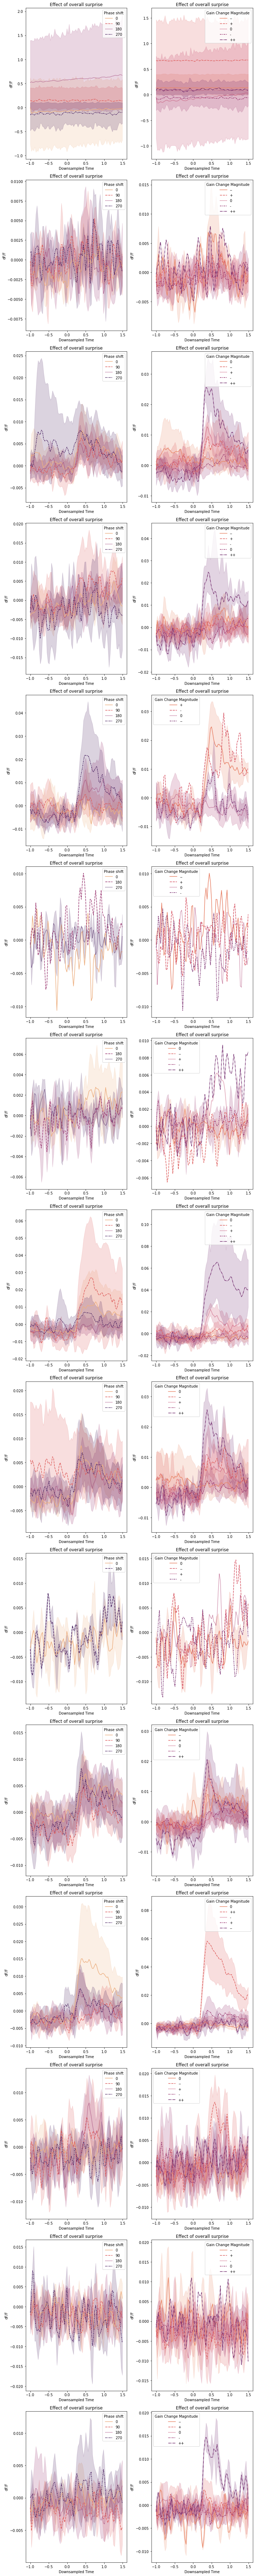

In [10]:
fig, axs = plt.subplots(15,2, figsize=(10,100))
for i,uid in enumerate(uids) :
    # Effect of overall surprise
    g = sns.lineplot(
        data=data_df_downsample[data_df_downsample['uid'] == uid],
        x="Downsampled Time",
        y="dF/F",
        hue="Phase shift",
        style="Phase shift",
        palette="flare",
        ax=axs[i,0],
    ).set_title("Effect of overall surprise")

    g = sns.lineplot(
        data=data_df_downsample[data_df_downsample['uid'] == uid],
        x="Downsampled Time",
        y="dF/F",
        hue='Gain Change Magnitude',
        style="Gain Change Magnitude",
        palette="flare",
        ax=axs[i,1], 
    ).set_title("Effect of overall surprise")

 
fig.tight_layout()
plt.show()

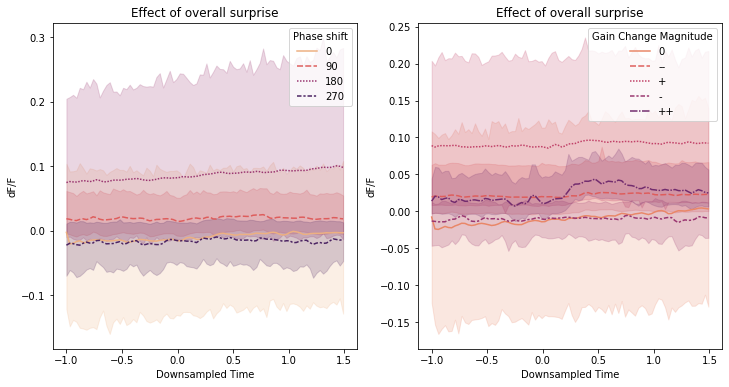

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

g = sns.lineplot(
    data=data_df_downsample,
    x="Downsampled Time",
    y="dF/F",
    hue="Phase shift",
    style="Phase shift",
    palette="flare",
    ax=axs[0],
).set_title("Effect of overall surprise")

g = sns.lineplot(
    data=data_df_downsample,
    x="Downsampled Time",
    y="dF/F",
    hue='Gain Change Magnitude',
    style="Gain Change Magnitude",
    palette="flare",
    ax=axs[1],
).set_title("Effect of overall surprise")

plt.show()

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

DATA_PATH = "../mouse_data/"

###########################################################
# Old data with Megha's 2 mice
###########################################################

def format_data(data):# rename gain changes
    data["Gain Change Magnitude"] = data["Gain Change Magnitude"].apply(lambda x: x[3:])

    # experiment params
    sinusoid_frequency = 50 / 3
    glitch_limits = (sinusoid_frequency * 0.2, sinusoid_frequency * 0.8)

    # define position glitch (0 +/- 20% : no, rest: yes)
    data["Phase shift"] = "other"
    data.loc[
        (data["Delta Position value"] <= glitch_limits[0])
        | (data["Delta Position value"] >= glitch_limits[1]),
        "Phase shift",
    ] = "Close to 0"
    data.loc[
        (data["Delta Position value"] >= glitch_limits[0])
        & (data["Delta Position value"] <= glitch_limits[1]),
        "Phase shift",
    ] = "Close to pi"


    # split trials by overall glitch magnitude
    data["Glitch magnitude"] = "minor"
    data.loc[
        (data["Phase shift"] == "Close to pi") & (data["Gain Change Magnitude"] != "0"),
        "Glitch magnitude",
    ] = "major"
    data.loc[
        (data["Phase shift"] == "Close to 0") & (data["Gain Change Magnitude"] == "0"),
        "Glitch magnitude",
    ] = "none"

    # split trials by glitch type
    data["Glitch type"] = "None"
    data.loc[
        (data["Phase shift"] == "Close to pi") & (data["Gain Change Magnitude"] == "0"),
        "Glitch type",
    ] = "Position glitch"
    data.loc[
        (data["Phase shift"] == "Close to 0") & (data["Gain Change Magnitude"] != "0"),
        "Glitch type",
    ] = "Speed glitch"
    data.loc[
        (data["Phase shift"] == "Close to pi") & (data["Gain Change Magnitude"] != "0"),
        "Glitch type",
    ] = "Both"
    return data

In [55]:
data = pd.read_csv(DATA_PATH + "mice_data_RL2_5.csv")
data = format_data(data)
data

,Unnamed: 0,Gain Change Magnitude,Delta Position,Delta Position value,Gain Pre,Gain Post,session_number,trial_number,Time Aligned to Gain Change (sec),dF/F,true_time,uid,Phase shift,Glitch magnitude,Glitch type
0,0,0,13.41 - 16.77,15.645347,0.3,0.3,0,1,0,-0.008142,-1.00,RL2_5,Close to 0,none,None
1,1,0,10.06 - 13.41,12.152564,1.0,1.0,0,2,0,-0.010617,-1.00,RL2_5,Close to pi,minor,Position glitch
2,2,0,6.71 - 10.06,9.115498,3.0,3.0,0,3,0,-0.005073,-1.00,RL2_5,Close to pi,minor,Position glitch
3,3,0,0.00 - 3.35,1.050403,0.3,0.3,0,4,0,-0.007042,-1.00,RL2_5,Close to 0,none,None
4,4,0,10.06 - 13.41,10.420366,3.0,3.0,0,5,0,0.011232,-1.00,RL2_5,Close to pi,minor,Position glitch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3149,3149,0,10.06 - 13.41,13.328588,1.0,1.0,0,34,82,0.000507,1.46,RL2_5,Close to pi,minor,Position glitch
3150,3150,0,13.41 - 16.77,16.497272,3.0,3.0,0,35,82,0.001882,1.46,RL2_5,Close to 0,none,None
3151,3151,0,3.35 - 6.71,4.997002,0.3,0.3,0,36,82,-0.016348,1.46,RL2_5,Close to pi,minor,Position glitch
3152,3152,0,0.00 - 3.35,1.637081,3.0,3.0,0,37,82,-0.007398,1.46,RL2_5,Close to 0,none,None


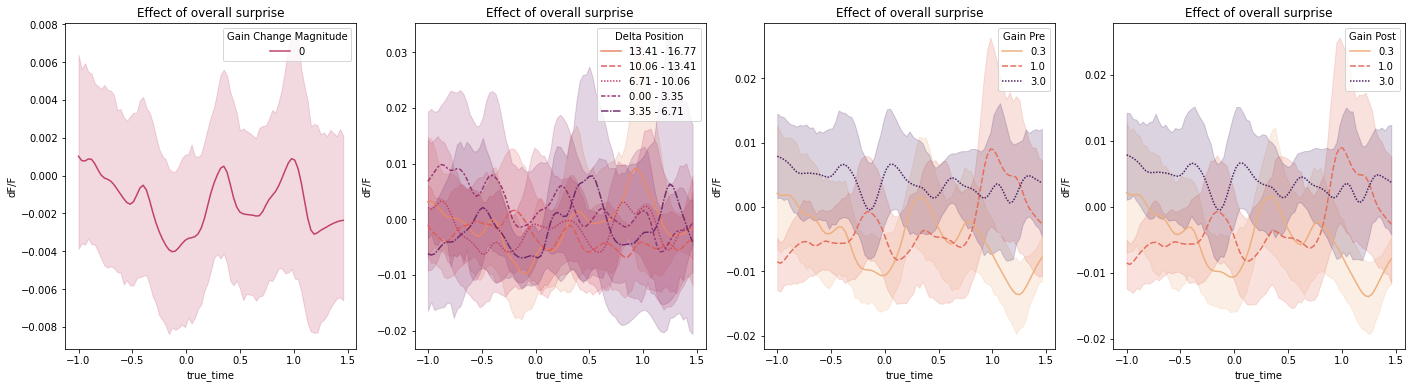

In [56]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))


g = sns.lineplot(
    data=data,
    x="true_time",
    y="dF/F",
    hue="Gain Change Magnitude",
    style="Gain Change Magnitude",
    palette="flare",
    ax=axs[0],
).set_title("Effect of overall surprise")

g = sns.lineplot(
    data=data,
    x="true_time",
    y="dF/F",
    hue='Delta Position',
    style="Delta Position",
    palette="flare",
    ax=axs[1],
).set_title("Effect of overall surprise")

g = sns.lineplot(
    data=data,
    x="true_time",
    y="dF/F",
    hue="Gain Pre",
    style="Gain Pre",
    palette="flare",
    ax=axs[2],
).set_title("Effect of overall surprise")

g = sns.lineplot(
    data=data,
    x="true_time",
    y="dF/F",
    hue='Gain Post',
    style="Gain Post",
    palette="flare",
    ax=axs[3],
).set_title("Effect of overall surprise")

plt.show()

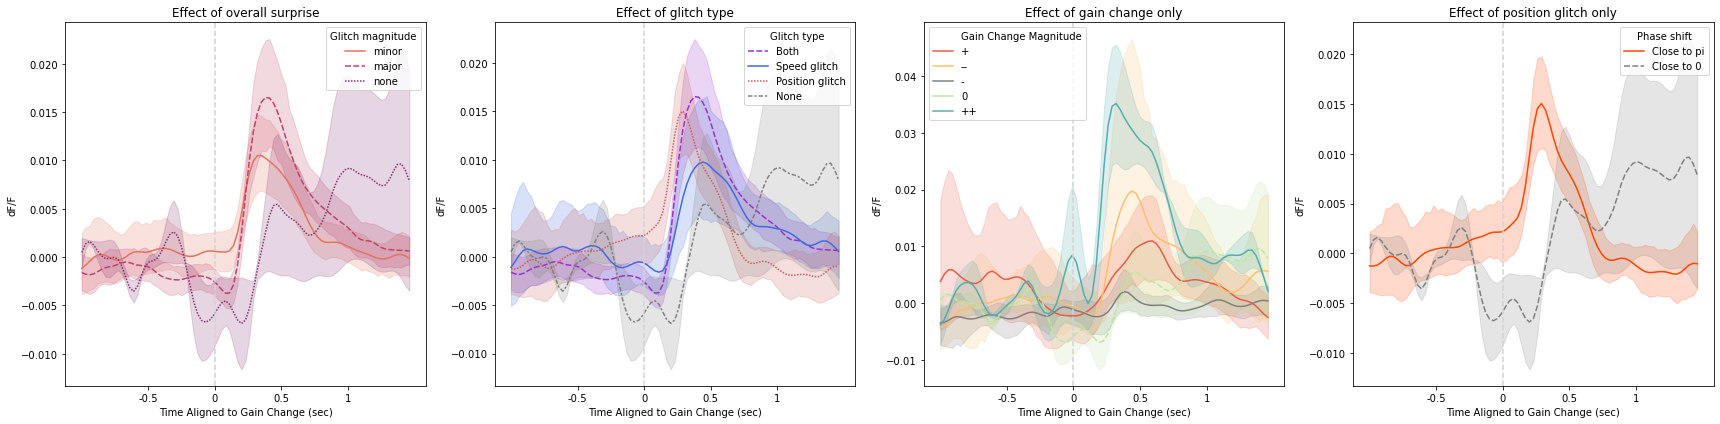

In [41]:

zero_mark = 100 / 3
xticks = [50 / 3, 100 / 3, 50, 200 / 3]
xtick_labels = [-0.5, 0, 0.5, 1]


def format_axes(ax: plt.Axes) -> None:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    yl = ax.get_ylim()
    ax.vlines(zero_mark, yl[0], yl[1], ls="--", color="lightgrey")
    ax.set_ylim(yl)


fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Effect of overall surprise
g = sns.lineplot(
    data=data,
    x="Time Aligned to Gain Change (sec)",
    y="dF/F",
    hue="Glitch magnitude",
    style="Glitch magnitude",
    palette="flare",
    ax=axs[0],
).set_title("Effect of overall surprise")
format_axes(g.axes)

# Modality specific vs combined glitches
g = sns.lineplot(
    data=data,
    x="Time Aligned to Gain Change (sec)",
    y="dF/F",
    hue="Glitch type",
    style="Glitch type",
    palette=["darkorchid", "royalblue", "indianred", "gray"],
    ax=axs[1],
    hue_order=["Both", "Speed glitch", "Position glitch", "None"],
).set_title("Effect of glitch type")
format_axes(g.axes)

# Signal split by gain change (no Phase shift)
colors = sns.color_palette("Spectral", 5)
colors[2] = "grey"
g = sns.lineplot(
    data=data[data["Phase shift"] == "Close to 0"],
    x="Time Aligned to Gain Change (sec)",
    y="dF/F",
    hue="Gain Change Magnitude",
    palette=colors,
    style="Glitch magnitude",
    ax=axs[2],
)
handles, labels = g.get_legend_handles_labels()
g.get_legend().remove()
g.legend(handles=handles[:6], labels=labels[:6])
g.set_title("Effect of gain change only")
format_axes(g.axes)

# Signal split by delta position (no gain change)
g = sns.lineplot(
    data=data[
        (data["Gain Change Magnitude"] == "0") & (data["Phase shift"] != "other")
    ],
    x="Time Aligned to Gain Change (sec)",
    y="dF/F",
    hue="Phase shift",
    style="Phase shift",
    palette=["orangered", "gray"],
    ax=axs[3],
).set_title("Effect of position glitch only")
format_axes(g.axes)

plt.tight_layout()
plt.show()